# Model Training

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

#### Import the CSV Data as Pandas DataFrame

In [87]:
#get current working directory
cwd = os.getcwd()

#read the csv
df = pd.read_csv(cwd + "/customer_booking.csv",  encoding="ISO-8859-1")

In [7]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [8]:
df_final = df.copy()

In [9]:
df_final.drop(columns=['route','booking_origin'], axis=1, inplace=True)

In [10]:
df_final.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,1,0,1,5.52,0


### Preparing X and Y variables

In [12]:
X = df_final.drop(columns=['booking_complete'],axis=1)

In [13]:
X.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2,Internet,RoundTrip,262,19,7,Sat,1,0,0,5.52
1,1,Internet,RoundTrip,112,20,3,Sat,0,0,0,5.52
2,2,Internet,RoundTrip,243,22,17,Wed,1,1,0,5.52
3,1,Internet,RoundTrip,96,31,4,Sat,0,0,1,5.52
4,2,Internet,RoundTrip,68,22,15,Wed,1,0,1,5.52


In [14]:
y = df_final['booking_complete']

In [15]:
y.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Train test split your data into X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric features (exclude object columns)
num_features = X_train.select_dtypes(exclude="object").columns

# Define categorical features (include only object columns)
cat_features = X_train.select_dtypes(include="object").columns

# Initialize transformers
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ],
    remainder="passthrough"  # Include any remaining columns as-is
)

# Fit and transform X_train
X_train_encoded = preprocessor.fit_transform(X_train)

# Get the feature names after transformation
new_columns = preprocessor.get_feature_names_out()

# Create a DataFrame with the transformed data and correct column names
X_train_encoded = pd.DataFrame(X_train_encoded, columns=new_columns)

# Transform X_test (using the preprocessor fitted on X_train)
X_test_encoded = preprocessor.transform(X_test)

In [17]:
X_train.shape, X_test.shape

((40000, 11), (10000, 11))

In [18]:
X_train_encoded.shape,X_test_encoded.shape

((40000, 20), (10000, 20))

Time to apply some changes on our training dataset:

#### Oversampling and undersampling using SMOTE-RUS Implementation

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over=SMOTE()
under=RandomUnderSampler()
steps=[('o', over), ('u', under)]
pipeline=Pipeline(steps=steps)

#transform the dataset using the SMOTE-RUS technique
X_train_new, y_train_new = pipeline.fit_resample(X_train_encoded, y_train)

In [22]:
print('Data has been balanced from both the classes \n', y_train_new.value_counts())

Data has been balanced from both the classes 
 booking_complete
0    34002
1    34002
Name: count, dtype: int64


## Model Training

### 1) RandomForest Classifier

#### 1.1 fitting the model scaled and oversampled dataset

In [26]:
from sklearn.ensemble import RandomForestClassifier

model1= RandomForestClassifier(max_depth =20 , criterion='gini', min_samples_split=5,random_state=0)
model1=model1.fit(X_train_new,y_train_new)

In [27]:
y_pred = model1.predict(X_test_encoded)

In [28]:
y_test.value_counts()

booking_complete
0    8520
1    1480
Name: count, dtype: int64

In [29]:
# Print classification report
from sklearn.metrics import classification_report

target_names=['Completed_Booking', 'Uncompleted_Booking']
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

  Completed_Booking       0.87      0.91      0.89      8520
Uncompleted_Booking       0.31      0.23      0.26      1480

           accuracy                           0.81     10000
          macro avg       0.59      0.57      0.58     10000
       weighted avg       0.79      0.81      0.80     10000



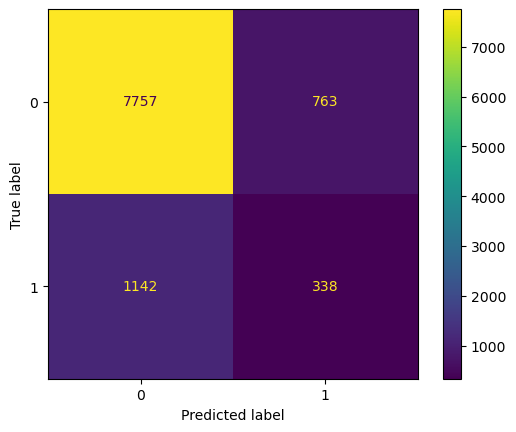

In [30]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 2. XgBoost Classifier

#### 2.1 fitting the model scaled and oversampled dataset

#### A. XGBoost with GridSearch

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define your parameter grid
param_grid = {
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [3, 5, 7],
  'n_estimators': [100, 200, 300]
}

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_new, y_train_new)  

# Get best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Make predictions on test data
y_pred = grid_search.predict(X_test_encoded)

# Evaluate model performance with a classification metric
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Accuracy: 0.8437


In [35]:
from sklearn.metrics import classification_report

# Convert continuous predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

target_names = ['Completed_Booking', 'Uncompleted_Booking']
print(classification_report(y_test, y_pred, target_names=target_names))


                     precision    recall  f1-score   support

  Completed_Booking       0.86      0.98      0.91      8520
Uncompleted_Booking       0.37      0.08      0.13      1480

           accuracy                           0.84     10000
          macro avg       0.61      0.53      0.52     10000
       weighted avg       0.79      0.84      0.80     10000



In [36]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for all classes and Extract only the probabilities for the positive class (class 1)
grid_search_probs = grid_search.predict_proba(X_test_encoded)[:, 1]

# Calculate ROC curve metrics for the grid search model
y_test_int = y_test.replace({'Completed_Booking' : 1, 'Uncompleted_Booking': 0})
fpr_grid, tpr_grid, thresholds_grid = roc_curve(y_test_int, grid_search_probs)
auc_grid = auc(fpr_grid, tpr_grid)


#### B. XGBoost with ROC curve

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

model_xg = XGBClassifier().fit(X_train_new, y_train_new)
y_pred_xgb= model_xg.predict(X_test_encoded)


In [39]:
print(classification_report(y_test, y_pred_xgb, target_names= target_names))

                     precision    recall  f1-score   support

  Completed_Booking       0.86      0.98      0.92      8520
Uncompleted_Booking       0.36      0.05      0.10      1480

           accuracy                           0.85     10000
          macro avg       0.61      0.52      0.51     10000
       weighted avg       0.78      0.85      0.79     10000



In [40]:
# Get predicted probabilities for all classes
probabilities = model_xg.predict_proba(X_test_encoded)

# Extract only the probabilities for the positive class (class 1)
probs_xg = probabilities[:, 1]

# Model Evaluation Metrics 
y_test_int = y_test.replace({'Completed_Booking' : 1, 'Uncompleted_Booking': 0})
auc_xg = roc_auc_score(y_test_int, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test_int, probs_xg)

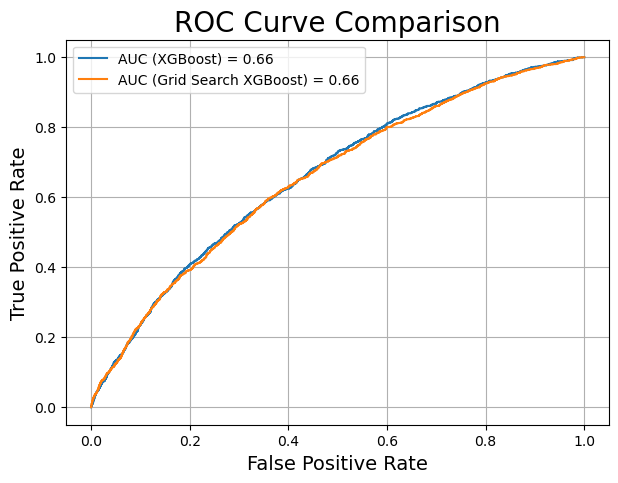

In [41]:
# Visualizing Model Performance: ROC Curve
from sklearn.metrics import roc_curve, auc

# Plot the ROC curves
plt.figure(figsize=(7, 5))

# Plot the ROC curve for the XGBoost model 
plt.plot(fpr_xg, tpr_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')  

# Plot the ROC curve for the grid search model
plt.plot(fpr_grid, tpr_grid, label=f'AUC (Grid Search XGBoost) = {auc_grid:.2f}')

plt.title('ROC Curve Comparison', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();
plt.grid(True)  # Add grid lines for better visualization

plt.show()

### Insights:

AUC Value: 

- TheXGBoost model has a slightly higher AUC (0.67) compared to the Grid Search XGBoost model (0.66).
- A higher AUC generally indicates better performance
- The curve for the Previous XGBoost model is slightly above the curve for the Grid Search XGBoost model, indicating a slightly higher true positive  rate for a given false positive rate.
- The XGBoost model is better at correctly identifying positive cases at various thresholds.

In [44]:
# Get feature importances
feature_importances = model_xg.feature_importances_

# Extract feature names without prefixes
feature_names = [name.split("__")[-1] for name in preprocessor.get_feature_names_out()]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


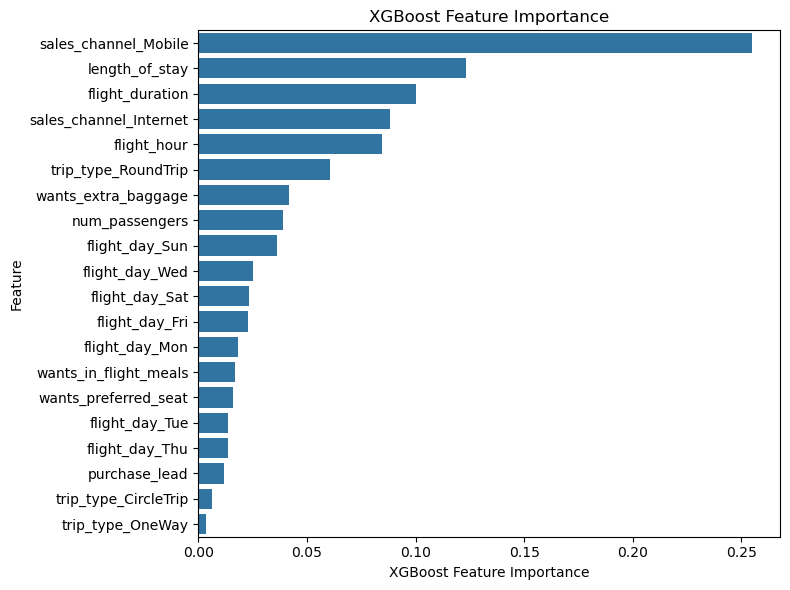

In [45]:
# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), color='tab:blue')
plt.xlabel("XGBoost Feature Importance")  # Change label to reflect XGBoost
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

#### Insights from the Feature Importance Plot:

- Sales channel, length of stay, and flight duration are the most influential factors.
- Customer preferences (extra baggage, seats, meals) have less impact.
- Purchase lead time has minimal effect on the outcome.

## Conclusion

In this project we dealt with an unbalanced dataset, with large categorical data.

    1. We addressed categorical data by applying encoding techniques, especially for large categorical features. Additionally, we utilized StandardScaler to scale certain features, using column transformer.

    2. To handle the unbalanced dataset we used oversampling and undersampling techniques to make our train data balanced and ready to be fitted in the model.

Then we trained 2 models:
    
    - RandomForest Classifier
    - XgBoost Classifier

#### Model Results

### 1. RandomForest Classifier

- On balanced data:  Acc : 0.81

  F1-Score :   Completed_Booking:  0.89
  
               Uncompleted_Booking: 0.28

### 2. XgBoostClassifier

- On balanced data: Acc : 0.84

  F1-Score : Completed_Booking: 0.91

             Uncompleted_Booking: 0.10

##### Final Results

Since we are dealing with unbalanced dataset the Acc metric is not enough to evaluate our model, so we will chose the best model based on it's F1-Score:

Best Model: XgBoost Classifier on Balanced data